# Customer Segmentation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# Unzipping and loading the Excel file
import zipfile
with zipfile.ZipFile('Online retail.zip', 'r') as zip_ref:
    zip_ref.extractall('Online_Retail')

# Load the Excel file into a DataFrame
df = pd.read_excel('Online_Retail/online_retail_II.xlsx')

# Display the first few rows of the dataset to understand its structure
print(df.head())

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [6]:
# Data Exploration and Preprocessing

# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

# Convert 'Invoice' column to string to avoid errors with non-string types
df['Invoice'] = df['Invoice'].astype(str)

# Remove rows with cancellations (Invoice starts with 'C')
df = df[~df['Invoice'].str.startswith('C')]  # Remove cancellations based on 'Invoice' column

# Drop rows with missing CustomerID
df.dropna(subset=['Customer ID'], inplace=True)  # Drop rows with missing CustomerID

# Check the datatypes of the columns
print("\nData Types and Non-Null Counts:")
print(df.info())

# Convert the InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



Missing values in the dataset:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
Index: 407695 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.0+ MB
None


In [7]:
# Feature Engineering (Creating Recency, Frequency, and Monetary features)

# Recency: Days since the last purchase
current_date = df['InvoiceDate'].max()
df['Recency'] = (current_date - df['InvoiceDate']).dt.days

# Calculate TotalSpent (Quantity * Price)
df['TotalSpent'] = df['Quantity'] * df['Price']

# Frequency: Total number of transactions per customer
frequency = df.groupby('Customer ID')['Invoice'].nunique()

# Monetary: Total spent per customer
monetary = df.groupby('Customer ID')['TotalSpent'].sum()

# Create a new DataFrame for RFM features
rfm_df = pd.DataFrame({
    'Recency': df.groupby('Customer ID')['Recency'].min(),  # Take the minimum recency for each customer
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

# Check the first few rows of the RFM DataFrame
print(rfm_df.head())

   Customer ID  Recency  Frequency  Monetary
0      12346.0      164         11    372.86
1      12347.0        2          2   1323.32
2      12348.0       73          1    222.16
3      12349.0       42          3   2671.14
4      12351.0       10          1    300.93


In [8]:
# Scaling the Data for clustering
# Check if there are any missing values before scaling
if rfm_df[['Recency', 'Frequency', 'Monetary']].isnull().sum().any():
    print("Missing values detected!")
else:
    # Proceed with scaling
    scaler = StandardScaler()
    rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]), 
                              columns=['Recency', 'Frequency', 'Monetary'])

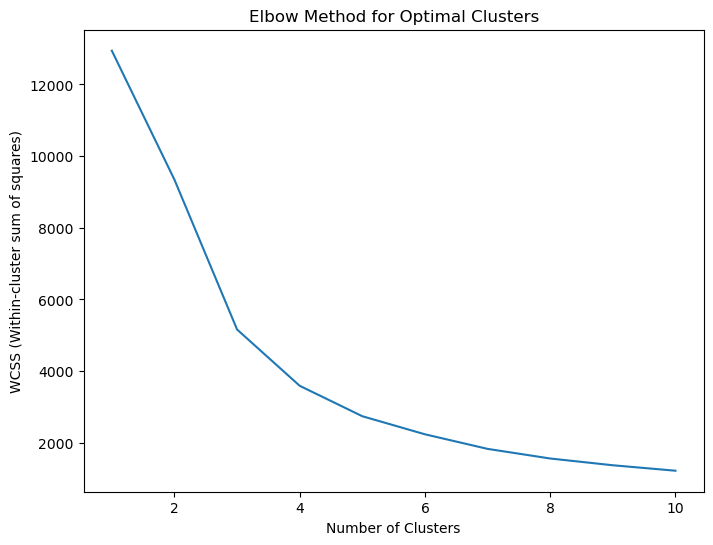

In [9]:
# Apply K-Means Clustering
# Using the Elbow Method to determine the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster sum of squares)')
plt.show()

# Fit K-Means with the optimal number of clusters
# From the Elbow plot, assume the optimal number of clusters is 4 (you can adjust based on your Elbow plot)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

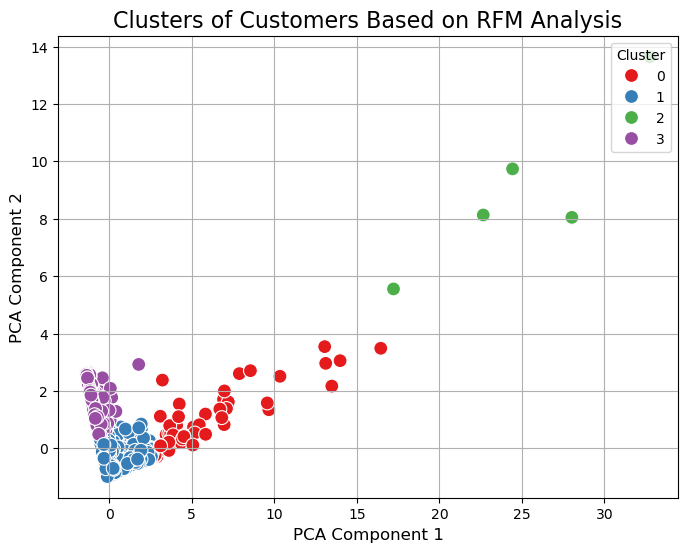

In [10]:
# Visualizing the Clusters with enhanced labels
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_df['Cluster'], palette='Set1', s=100, marker='o')

plt.title('Clusters of Customers Based on RFM Analysis', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster', loc='upper right', fontsize=10)
plt.grid(True)
plt.show()

In [11]:
# Analyze the Cluster Centers
# Check the cluster centers to understand the characteristics of each cluster
cluster_centers = kmeans.cluster_centers_

# Print the cluster centers (after inverse scaling for original values)
print("\nCluster Centers (in original scale):")

# Inverse transform the cluster centers to bring them back to the original scale
original_centers = scaler.inverse_transform(cluster_centers)

# Create a DataFrame to easily view the results
cluster_centers_df = pd.DataFrame(original_centers, columns=['Recency', 'Frequency', 'Monetary'])
cluster_centers_df.index = [f"Cluster {i}" for i in range(1, len(cluster_centers_df) + 1)]

print(cluster_centers_df)


Cluster Centers (in original scale):
              Recency   Frequency       Monetary
Cluster 1   13.271186   46.033898   28018.434966
Cluster 2   42.069978    4.433302    1710.796375
Cluster 3    4.600000  113.600000  215543.670000
Cluster 4  242.086749    1.658723     595.746486


In [12]:
# Further Analysis (Optional)
# Analyze the characteristics of each cluster (e.g., average recency, frequency, monetary)

# Compute the mean, median, and standard deviation for each cluster
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})

# Print the cluster summary
print("\nCluster Summary:")
print(cluster_summary)

# Optionally, count the number of customers in each cluster
cluster_counts = rfm_df['Cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)


Cluster Summary:
            Recency                     Frequency                    \
               mean median        std        mean median        std   
Cluster                                                               
0         13.271186    3.0  34.983164   46.033898   38.0  29.692659   
1         42.069978   32.0  34.892130    4.433302    3.0   4.129997   
2          4.600000    6.0   4.335897  113.600000   94.0  51.829528   
3        242.086749  233.0  66.006022    1.658723    1.0   1.221555   

              Monetary                           
                  mean     median           std  
Cluster                                          
0         28018.434966   20329.68  19699.235589  
1          1710.796375     924.52   2320.354547  
2        215543.670000  196566.74  87157.722931  
3           595.746486     306.00   1449.148948  

Cluster Counts:
Cluster
1    3201
3    1049
0      59
2       5
Name: count, dtype: int64
